In [2]:
# Importing dependencies
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import torch.optim as optim
import seaborn as sns
import random as rand

sns.set()

### Generating Sample Data

Text(0.5, 1.0, 'Temperature vs Time with Noise')

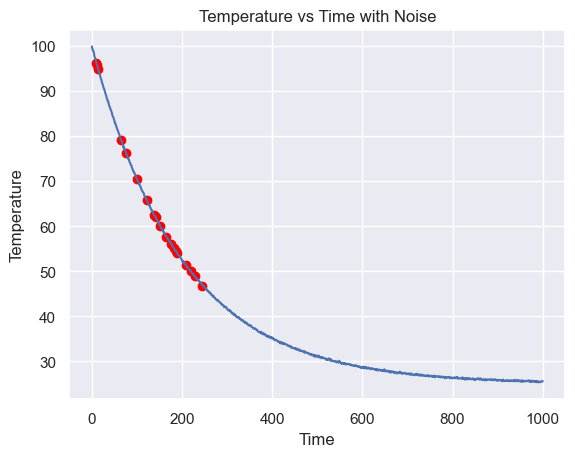

In [3]:
# Define Newton's Cooling Law
def f(t, y):
  r = 0.005  # Cooling rate
  y_env = 25  # Environment temperature
  return r*(y_env - y)  # Rate of change of temperature

# Initial conditions
y0 = 100
t0 = 0

# Time values and step size
t_values = np.linspace(0, 1000, 1000)
dt = t_values[1] - t_values[0]

# Lists for time and temperature data
t_data = [t0]
y_data = [y0]

# Solve the differential equation using Euler's method
for t in t_values[1:]:
  y_n = y_data[-1] + f(t_data[-1], y_data[-1]) * dt
  y_data.append(y_n)
  t_data.append(t)

# Convert lists to numpy arrays
y_data, t_data = np.array(y_data), np.array(t_data)

# Add Gaussian noise to the temperature data
noise_level = 0.1
noise = np.random.normal(loc=0, scale=noise_level, size=y_data.shape)
noisy_data = y_data + noise

# Select a random sample of data points
n_data = 20
data_till = 250
early_sample = noisy_data[:data_till]
early_sample_t = t_data[:data_till]
random_indices = np.random.choice(np.arange(early_sample.shape[0]), size=n_data, replace=False)
random_sample = early_sample[random_indices]
random_t = early_sample_t[random_indices]

# Plot the data
plt.scatter(random_t, random_sample, c='red')
plt.plot(t_data, noisy_data)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature vs Time with Noise')

### Pre-processing Data

In [15]:
device = torch.device('cpu')

# Convert data to PyTorch tensors and move to device
x_data = torch.tensor(random_t, dtype=torch.float32).view(-1, 1).to(device)  # Convert time data to tensor
y_data = torch.tensor(random_sample, dtype=torch.float32).view(-1, 1).to(device)  # Convert temperature data to tensor

# Convert test data to PyTorch tensors and move to device
test_data = torch.tensor(t_data, dtype=torch.float32).view(-1, 1).to(device)  # Convert time data to tensor
test_y_data = torch.tensor(noisy_data, dtype=torch.float32).view(-1, 1).to(device)  # Convert temperature data to tensor

### Initializing Model

In [16]:

# Define a simple neural network with 4 fully connected layers
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(1, 50).to(device)  # First layer
        self.fc2 = nn.Linear(50, 50).to(device)  # Second layer
        self.fc3 = nn.Linear(50, 50).to(device)  # Third layer
        self.fc4 = nn.Linear(50, 1).to(device)   # Fourth layer
        self.r = nn.Parameter(data=torch.tensor([0.])).to(device)  # Parameter for the cooling rate

    # Define the forward pass
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation function after third layer
        x = self.fc4(x)  # No activation function after fourth layer
        return x

# Define a function to compute the gradient of a tensor
def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input."""
    return torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )

# Define a function to compute the physics-informed loss
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(device)  # Time tensor
    temps = model(ts)  # Temperature predictions
    dT = grad(temps, ts)[0]  # Temperature gradient
    y_env = 25  # Environment temperature
    pde = model.r * (25 - temps) - dT  # Physics-informed differential equation

    return torch.mean(pde**2)  # Return the mean squared error of the PDE

### Training Model

In [19]:
# Instantiate two models and move to device
model_with_physics = SimpleNN().to(device)
model_without_physics = SimpleNN().to(device)

model_with_physics.train()  # Set the model to training mode
model_without_physics.train()  # Set the model to training mode

# Define two optimizers and learning rate schedulers
optimizer_with_physics = optim.Adam(model_with_physics.parameters(), lr=0.01)  # Adam optimizer
optimizer_without_physics = optim.Adam(model_without_physics.parameters(), lr=0.01)  # Adam optimizer

scheduler_with_physics = optim.lr_scheduler.ReduceLROnPlateau(optimizer_with_physics, mode='min', patience=10, factor=0.5, verbose=True)  # Learning rate scheduler
scheduler_without_physics = optim.lr_scheduler.ReduceLROnPlateau(optimizer_without_physics, mode='min', patience=10, factor=0.5, verbose=True)  # Learning rate scheduler

# Initialize variables for tracking the best model and loss
best_loss_with_physics = float('inf')
best_loss_without_physics = float('inf')

best_model_with_physics = None
best_model_without_physics = None

# Define the loss function
mse_loss = nn.MSELoss()
mse_loss_physics = nn.MSELoss()

# Train the model
n_epochs = 10000
for epoch in range(n_epochs):
    # Forward pass
    outputs_with_physics = model_with_physics(x_data)  # Compute the model output
    outputs_without_physics = model_without_physics(x_data)  # Compute the model output

    loss_with_physics = mse_loss_physics(outputs_with_physics, y_data)  # Compute the loss
    loss_without_physics = mse_loss(outputs_without_physics, y_data)  # Compute the loss

    # Adding extra physics term
    pinn_loss = physics_loss(model_with_physics)  # Compute the physics-informed loss
    loss_with_physics += 3*pinn_loss  # Add the physics-informed loss to the total loss

    # Backward pass and optimization
    optimizer_with_physics.zero_grad()  # Zero the gradients
    optimizer_without_physics.zero_grad()  # Zero the gradients

    loss_with_physics.backward()  # Compute the gradients
    loss_without_physics.backward()  # Compute the gradients

    optimizer_with_physics.step()  # Update the weights
    optimizer_without_physics.step()  # Update the weights

    # Print the loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss with physics: {loss_with_physics.item():.4f}, Loss without physics: {loss_without_physics.item():.4f}')
        
        # Validation
        with torch.no_grad():
            val_outputs_with_physics = model_with_physics(test_data)
            val_outputs_without_physics = model_without_physics(test_data)

            val_loss_with_physics = mse_loss(val_outputs_with_physics, test_y_data)
            val_loss_without_physics = mse_loss(val_outputs_without_physics, test_y_data)

        # Adjust learning rate based on validation loss
        scheduler_with_physics.step(val_loss_with_physics)
        scheduler_without_physics.step(val_loss_without_physics)
        
        # Save the best model based on validation loss
        if val_loss_with_physics < best_loss_with_physics:
            best_loss_with_physics = val_loss_with_physics
            best_model_with_physics = model_with_physics.state_dict()
        
        if val_loss_without_physics < best_loss_without_physics:
            best_loss_without_physics = val_loss_without_physics
            best_model_without_physics = model_without_physics.state_dict()

# Load the best models
model_with_physics.load_state_dict(best_model_with_physics)
model_without_physics.load_state_dict(best_model_without_physics)

# Compute the model output on the test data
model_with_physics.eval()  # Set the model to evaluation mode
model_without_physics.eval()  # Set the model to evaluation mode
predicted_with_physics = model_with_physics(test_data).detach().numpy()
predicted_without_physics = model_without_physics(test_data).detach().numpy()


Epoch [100/10000], Loss with physics: 1638.1962, Loss without physics: 1522.3127
Epoch [200/10000], Loss with physics: 18.7643, Loss without physics: 55.0616
Epoch [300/10000], Loss with physics: 0.7030, Loss without physics: 35.5074
Epoch [400/10000], Loss with physics: 2.2357, Loss without physics: 5.5321
Epoch [500/10000], Loss with physics: 11.7215, Loss without physics: 4.8109
Epoch [600/10000], Loss with physics: 1.5211, Loss without physics: 1.2549
Epoch [700/10000], Loss with physics: 2.9838, Loss without physics: 1.0018
Epoch [800/10000], Loss with physics: 0.7928, Loss without physics: 6.2782
Epoch [900/10000], Loss with physics: 2.0617, Loss without physics: 1.8718
Epoch [1000/10000], Loss with physics: 0.8271, Loss without physics: 6.9258
Epoch [1100/10000], Loss with physics: 4.6299, Loss without physics: 2.7273
Epoch [1200/10000], Loss with physics: 0.8946, Loss without physics: 0.2879
Epoch [1300/10000], Loss with physics: 1.4078, Loss without physics: 3.5608
Epoch [1400

### Plotting Results

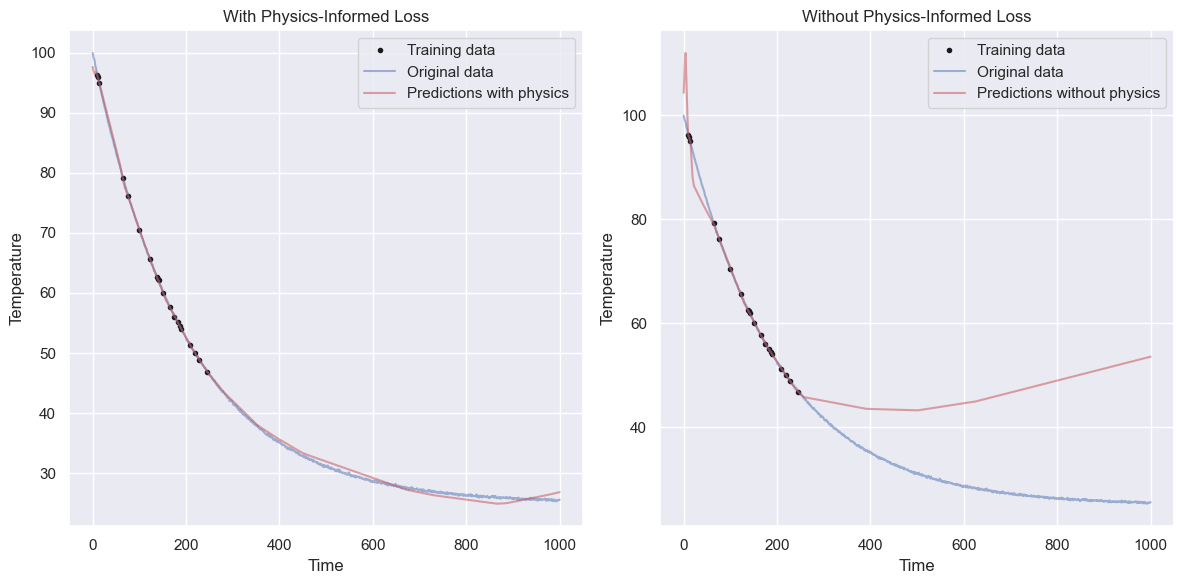

In [20]:
# Plot the data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_data, y_data, 'k.', label='Training data')  # Plot the training data
plt.plot(test_data, test_y_data, 'b', label='Original data', alpha=0.5)  # Plot the original data
plt.plot(test_data, predicted_with_physics, 'r', label='Predictions with physics', alpha=0.5)  # Plot the model predictions
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Temperature')  # Label the y-axis
plt.title('With Physics-Informed Loss')  # Add a title
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid

plt.subplot(1, 2, 2)
plt.plot(x_data, y_data, 'k.', label='Training data')  # Plot the training data
plt.plot(test_data, test_y_data, 'b', label='Original data', alpha=0.5)  # Plot the original data
plt.plot(test_data, predicted_without_physics, 'r', label='Predictions without physics', alpha=0.5)  # Plot the model predictions
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Temperature')  # Label the y-axis
plt.title('Without Physics-Informed Loss')  # Add a title
plt.legend()  # Add a legend
plt.grid(True)  # Add a grid

plt.tight_layout()
plt.show()  # Display the plot